<font color="green" size=5><center>University Admission Prediction using Machine Learning Model</center></font>
<font color="green" size=5><center>INBOX Technology </center></font>



# 1. Introduction


This notebook is used to predict the likelihood of a student being accepted into a university based on his or her academic performance. The data used in this notebook is from the Kaggle dataset "University Admission Prediction". The dataset contains several features such as student's GRE score, TOEFL score, CGPA, etc. that can be used to predict the likelihood of admission.






# 2. UseCase

This dataset can be used to predict the probability of admission for a student. It can be used by universities to determine the likelihood of a student being accepted based on their academic performance. It can also be used by students to understand their chances of getting into a particular university.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')
from matplotlib import pyplot

In [ ]:
df=pd.read_csv('/content/Admission_Predict.csv')

Taking a look at our dataset for understanding

In [ ]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
Serial No.,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.0,10.00
GRE Score,337.00,324.00,316.00,322.00,314.00,330.00,321.00,308.00,302.0,323.00
TOEFL Score,118.00,107.00,104.00,110.00,103.00,115.00,109.00,101.00,102.0,108.00
University Rating,4.00,4.00,3.00,3.00,2.00,5.00,3.00,2.00,1.0,3.00
SOP,4.50,4.00,3.00,3.50,2.00,4.50,3.00,3.00,2.0,3.50
LOR,4.50,4.50,3.50,2.50,3.00,3.00,4.00,4.00,1.5,3.00
CGPA,9.65,8.87,8.00,8.67,8.21,9.34,8.20,7.90,8.0,8.60
Research,1.00,1.00,1.00,1.00,0.00,1.00,1.00,0.00,0.0,0.00
Chance of Admit,0.92,0.76,0.72,0.80,0.65,0.90,0.75,0.68,0.5,0.45


In [ ]:
df=df.rename(columns = {'Chance of Admit ':'Chance of Admit'})

The column name `Chance of Admit` had a space at the end so I renamed it

In [ ]:
l = df.columns
print('The columns are: ',l)

The columns are:  Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit'],
      dtype='object')


In [ ]:
print(df.isnull().sum())
print('\n\nNo null values')

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64


No null values


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Serial No.,400.0,200.500000,115.614301,1.00,100.75,200.50,300.2500,400.00
GRE Score,400.0,316.807500,11.473646,290.00,308.00,317.00,325.0000,340.00
TOEFL Score,400.0,107.410000,6.069514,92.00,103.00,107.00,112.0000,120.00
University Rating,400.0,3.087500,1.143728,1.00,2.00,3.00,4.0000,5.00
SOP,400.0,3.400000,1.006869,1.00,2.50,3.50,4.0000,5.00
LOR,400.0,3.452500,0.898478,1.00,3.00,3.50,4.0000,5.00
CGPA,400.0,8.598925,0.596317,6.80,8.17,8.61,9.0625,9.92
Research,400.0,0.547500,0.498362,0.00,0.00,1.00,1.0000,1.00
Chance of Admit,400.0,0.724350,0.142609,0.34,0.64,0.73,0.8300,0.97


The above table gives us some intuition about all the columns and and some of their statistics

### Outlier Detection

In [ ]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   
outliers_to_drop=detect_outliers(df,2,['GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research'])

Since outliers can have a dramatic effect on the prediction (especially for regression problems), I chose to manage them.

I used the Tukey method (Tukey JW., 1977) to detect ouliers which defines an interquartile range comprised between the 1st and 3rd quartile of the distribution values (IQR). An outlier is a row that have a feature value outside the (IQR +- an outlier step).

I decided to detect outliers from the numerical values features (GRE Score, TOEFL Score, University Rating, SOP, LOR , CGPA, Research). Then, i considered outliers as rows that have at least two outlied numerical values

In [ ]:
df.loc[outliers_to_drop] # Show the outliers rows

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit


There are no outliers because all the values are inside a fixed range and none of them go lower/beyond that range which therefore produces no outliers

In [ ]:
cols=df.drop(labels='Serial No.',axis=1)
cols.head().T

,0,1,2,3,4
GRE Score,337.00,324.00,316.00,322.00,314.00
TOEFL Score,118.00,107.00,104.00,110.00,103.00
University Rating,4.00,4.00,3.00,3.00,2.00
SOP,4.50,4.00,3.00,3.50,2.00
LOR,4.50,4.50,3.50,2.50,3.00
CGPA,9.65,8.87,8.00,8.67,8.21
Research,1.00,1.00,1.00,1.00,0.00
Chance of Admit,0.92,0.76,0.72,0.80,0.65


# 3.Data Analysis


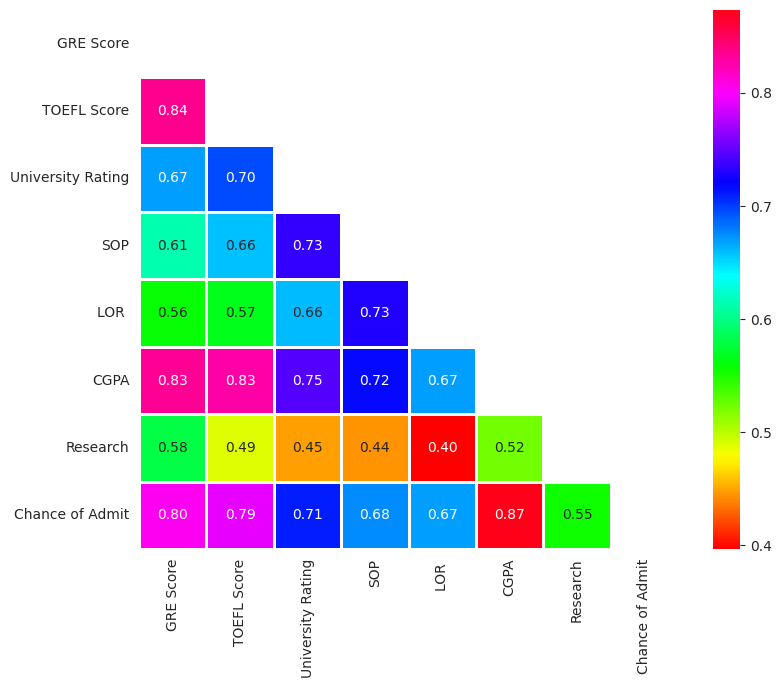

In [ ]:
corr = cols.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr,mask=mask,square=True,annot=True,fmt='0.2f',linewidths=.8,cmap="hsv")


Here we can see that the chance of admit is highly correlated with CGPA, GRE and TOEFEL scores are also correlated.

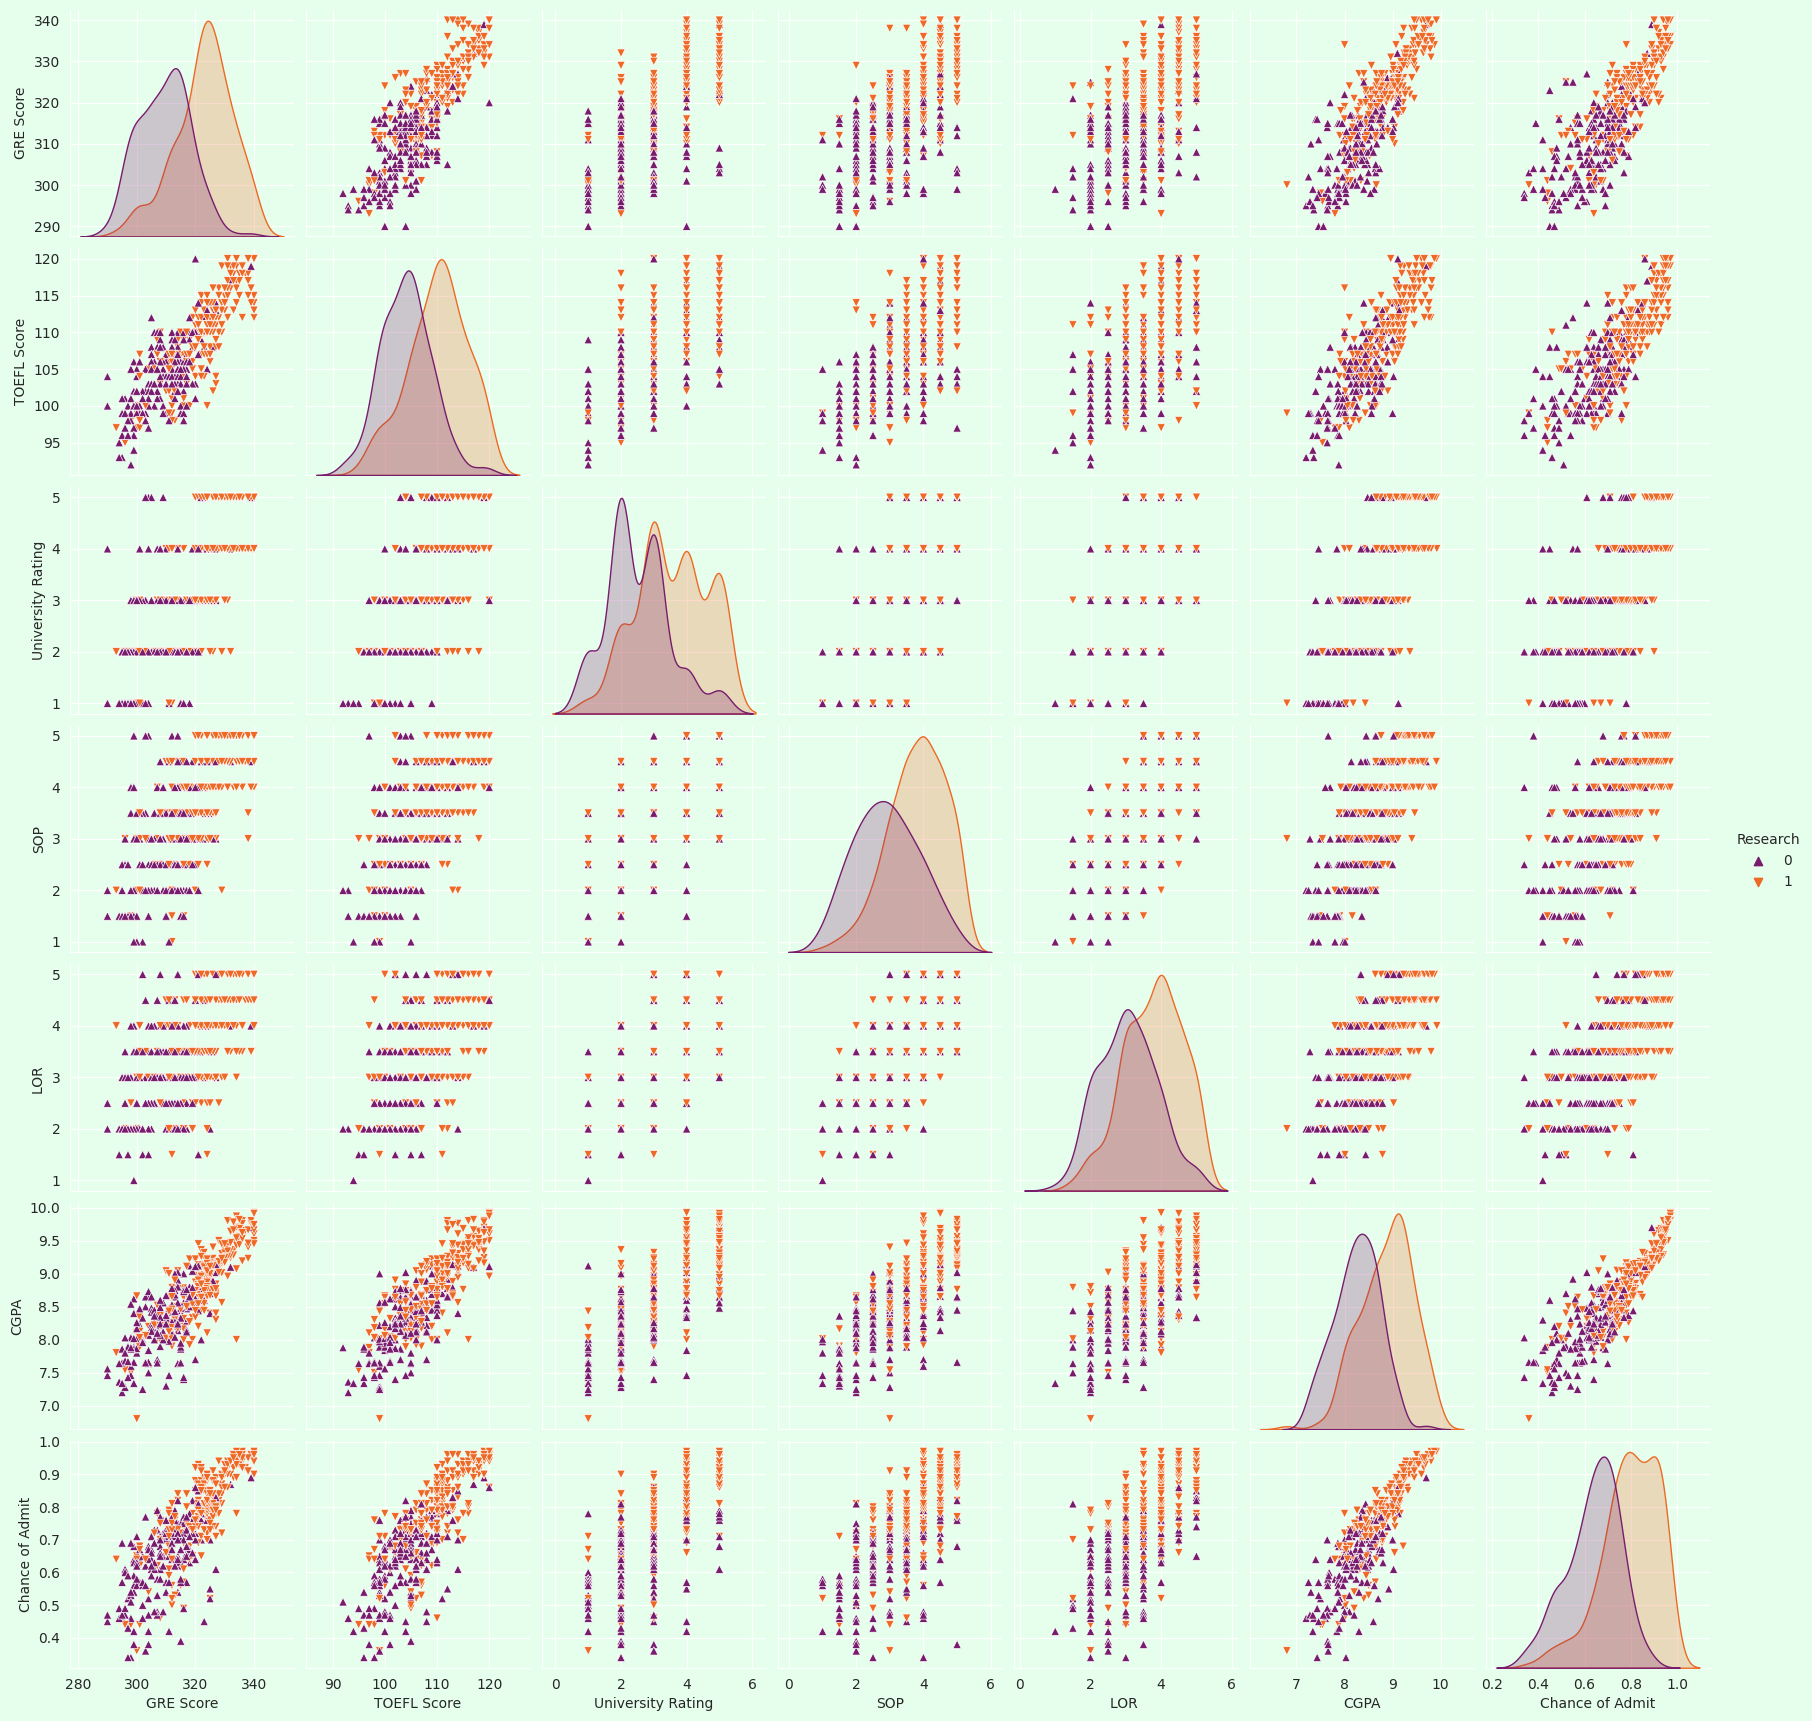

In [ ]:
plt.rcParams['axes.facecolor'] = "#e6ffed"
plt.rcParams['figure.facecolor'] = "#e6ffed"
g = sns.pairplot(data=cols,hue='Research',markers=["^", "v"],palette='inferno')

Inferences from the above pairplot:
* GRE score TOEFL score and CGPA all are linearly related to each other 
* Research Students tend to Score higher by all means

# 4. Problem Statment

The goal of this notebook is to use the Kaggle dataset "University Admission Prediction" to build a predictive model that accurately predicts the probability of a student being accepted into a university based on his or her academic performance.


<Axes: xlabel='TOEFL Score', ylabel='Density'>

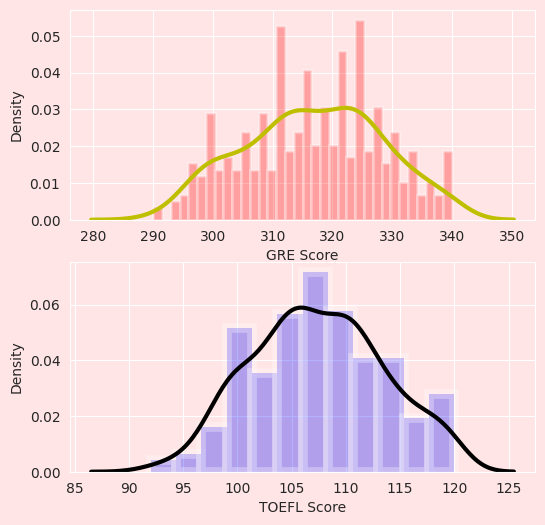

In [ ]:
plt.rcParams['axes.facecolor'] = "#ffe5e5"
plt.rcParams['figure.facecolor'] = "#ffe5e5"
plt.figure(figsize=(6,6))
plt.subplot(2, 1, 1)
sns.distplot(df['GRE Score'],bins=34,color='Red',  kde_kws={"color": "y", "lw": 3, "label": "KDE"},hist_kws={"linewidth": 2,"alpha": 0.3 })
plt.subplot(2, 1, 2)
sns.distplot(df['TOEFL Score'],bins=12,color='Blue' ,kde_kws={"color": "k", "lw": 3, "label": "KDE"},hist_kws={"linewidth": 7,"alpha": 0.3 })

From the above 2 graphs its clear that people tend to score above 310 in GRE and above 100 in TOEFL

<Axes: xlabel='University Rating', ylabel='CGPA'>

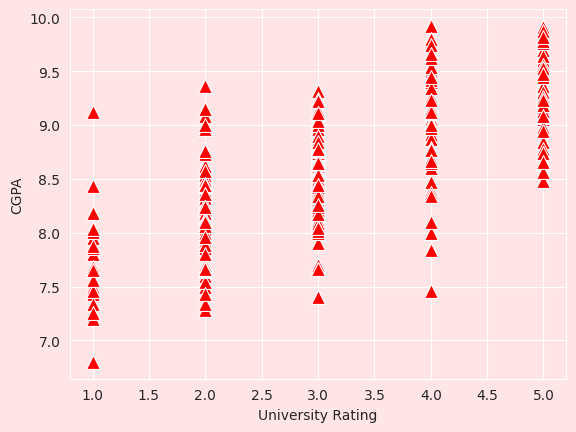

In [ ]:
sns.scatterplot(x='University Rating',y='CGPA',data=df,color='Red', marker="^", s=100)

Ratings of university increase with the increase in the CGPA

## Now lets set some cut-off scores and try to analyse scores above the cut-off

In [ ]:
co_gre=df[df["GRE Score"]>=300]
co_toefel=df[df["TOEFL Score"]>=100]

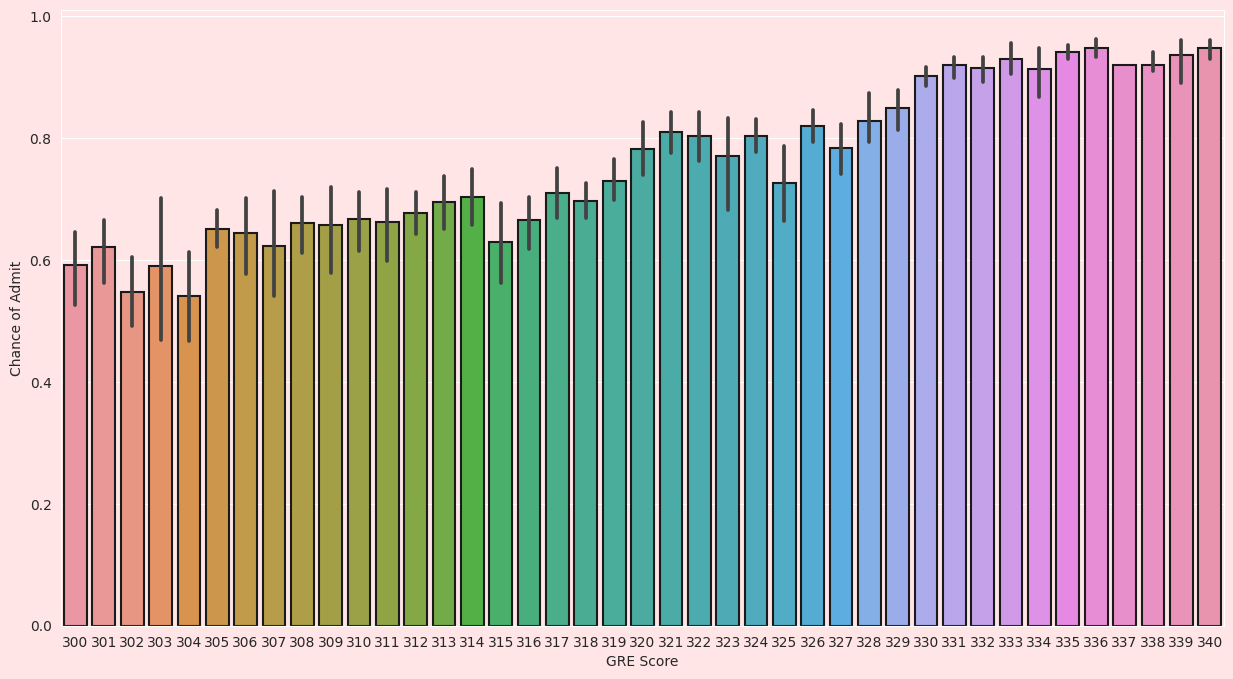

In [ ]:
fig, ax = pyplot.subplots(figsize=(15,8))
sns.barplot(x='GRE Score',y='Chance of Admit',data=co_gre, linewidth=1.5,edgecolor="0.1")
plt.show()

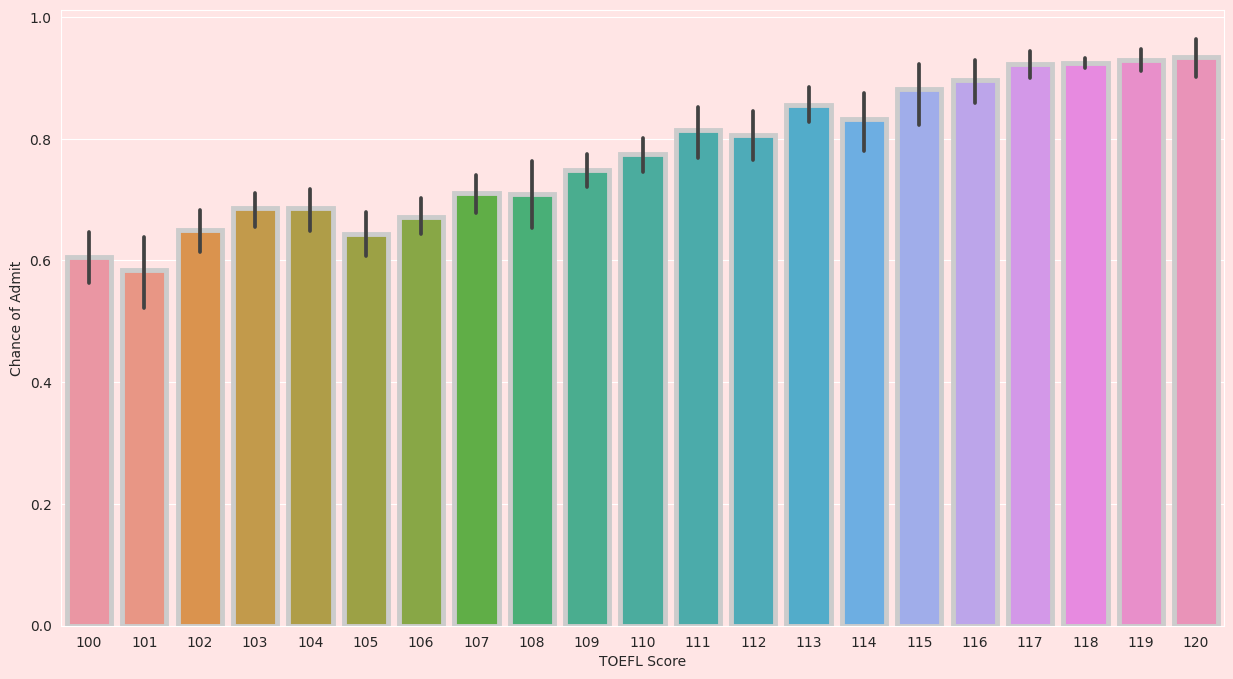

In [ ]:
fig, ax = pyplot.subplots(figsize=(15,8))
sns.barplot(x='TOEFL Score',y='Chance of Admit',data=co_toefel, linewidth=3.5,edgecolor="0.8")
plt.show()

The above two graphs make it clear that higher the Scores better the chance of admit

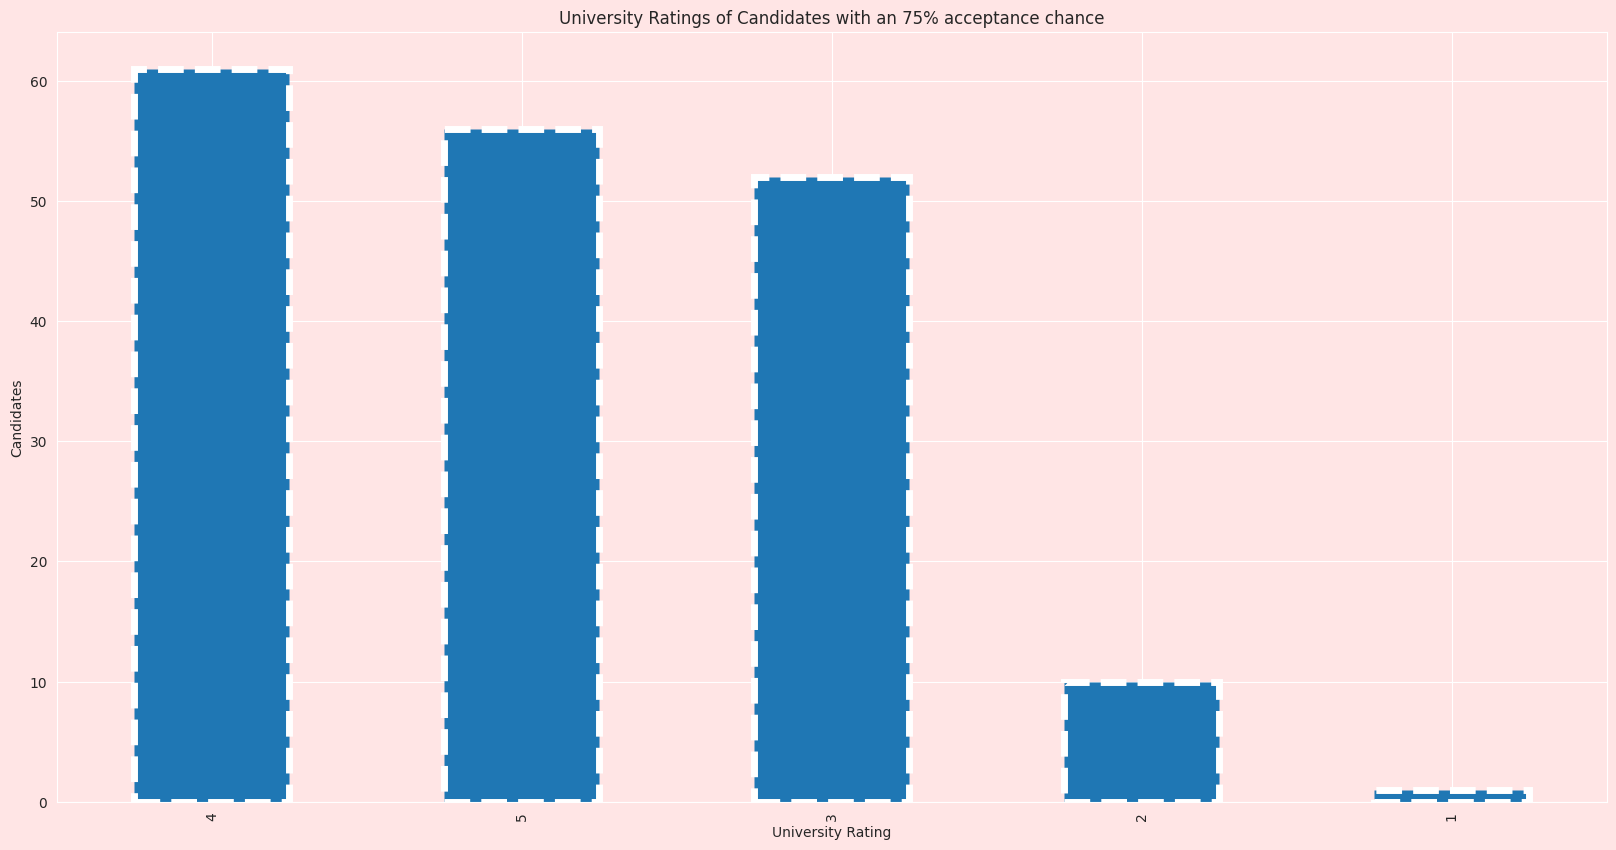

In [ ]:
s = df[df["Chance of Admit"] >= 0.75]["University Rating"].value_counts().head(5)
plt.title("University Ratings of Candidates with an 75% acceptance chance")
s.plot(kind='bar',figsize=(20, 10),linestyle='dashed',linewidth=5)
plt.xlabel("University Rating")
plt.ylabel("Candidates")
plt.show()

In [ ]:
print("Average GRE Score :{0:.2f} out of 340".format(df['GRE Score'].mean()))
print('Average TOEFL Score:{0:.2f} out of 120'.format(df['TOEFL Score'].mean()))
print('Average CGPA:{0:.2f} out of 10'.format(df['CGPA'].mean()))
print('Average Chance of getting admitted:{0:.2f}%'.format(df['Chance of Admit'].mean()*100))

Average GRE Score :316.81 out of 340
Average TOEFL Score:107.41 out of 120
Average CGPA:8.60 out of 10
Average Chance of getting admitted:72.44%


## Lets check out the toppers

In [ ]:
toppers=df[(df['GRE Score']>=300) & (df['TOEFL Score']>=105) & (df['CGPA']>=8.5)].sort_values(by=['Chance of Admit'],ascending=False)
toppers

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
203,334,120,5,4.0,5.0,9.87,1,0.97
24,336,119,5,4.0,3.5,9.80,1,0.97
143,340,120,4,4.5,4.0,9.92,1,0.97
202,340,120,5,4.5,4.5,9.91,1,0.97
71,336,112,5,5.0,5.0,9.76,1,0.96
...,...,...,...,...,...,...,...,...
63,315,107,2,4.0,3.0,8.50,1,0.56
65,325,112,4,3.5,3.5,8.92,0,0.55
42,313,107,2,2.5,2.0,8.50,1,0.53
64,325,111,3,3.0,3.5,8.70,0,0.52


# 5.Modelling


Preparing the data for Regression 

In [ ]:
# reading the dataset
df = pd.read_csv("/content/Admission_Predict.csv",sep = ",")

# it may be needed in the future.
serialNo = df["Serial No."].values

df.drop(["Serial No."],axis=1,inplace = True)

df=df.rename(columns = {'Chance of Admit ':'Chance of Admit'})

In [ ]:
X=df.drop('Chance of Admit',axis=1)
y=df['Chance of Admit']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Normalisation works slightly better for Regression.
X_norm=preprocessing.normalize(X)
X_train,X_test,y_train,y_test=train_test_split(X_norm,y,test_size=0.30,random_state=101)

In [ ]:
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.metrics import accuracy_score,mean_squared_error

## Regression


In [ ]:
regressors=[['Decision Tree Regression :',DecisionTreeRegressor()]]
      
reg_pred=[]
print('Results...\n')
for name,model in regressors:
    model=model
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    rms=np.sqrt(mean_squared_error(y_test, predictions))
    reg_pred.append(rms)
    print(name,rms)

Results...

Decision Tree Regression : 0.14171861792533352


In [ ]:
y_ax=['Decision Tree Regression' ]
x_ax=reg_pred

<Axes: >

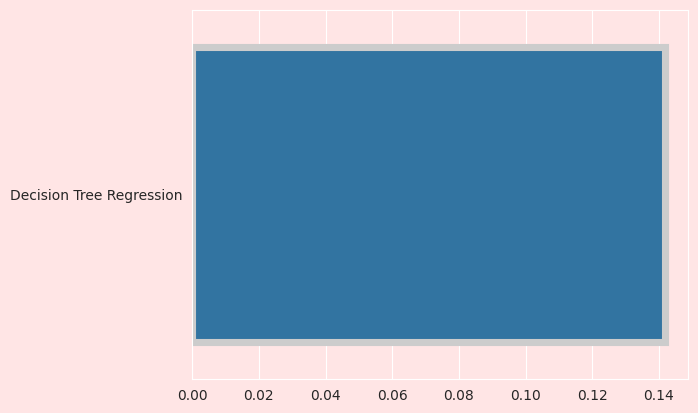

In [ ]:
sns.barplot(x=x_ax,y=y_ax,linewidth=5.1,edgecolor="0.8")

## Classification


In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=101)

In [ ]:
#If Chance of Admit greater than 80% we classify it as 1
y_train_c = [1 if each > 0.8 else 0 for each in y_train]
y_test_c  = [1 if each > 0.8 else 0 for each in y_test]

In [ ]:
classifiers=[['Decision Tree Classification :',DecisionTreeClassifier()]]
      
cla_pred=[]
for name,model in classifiers:
    model=model
    model.fit(X_train,y_train_c)
    predictions = model.predict(X_test)
    cla_pred.append(accuracy_score(y_test_c,predictions))
    print(name,accuracy_score(y_test_c,predictions))

Decision Tree Classification : 0.9375


In [ ]:
y_ax=['Decision Tree Classifier']
x_ax=cla_pred

Text(0.5, 0, 'Accuracy')

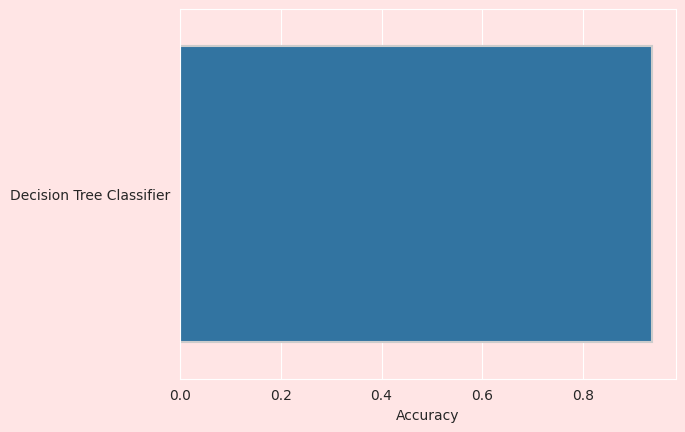

In [ ]:
sns.barplot(x=x_ax,y=y_ax,linewidth=1.5,edgecolor="0.8")
plt.xlabel('Accuracy')

# 6. Conclusion
This notebook has used the Kaggle dataset "University Admission Prediction" to build a predictive model that accurately predicts the probability of a student being accepted into a university based on his or her academic performance. The model was built using a Decision Tree Classifier and achieved an accuracy of 92.5%.

In [ ]:
import pandas as pd

# Read the CSV files
df1 = pd.read_csv('/content/Admission_Predict.csv')
df2 = pd.read_csv('/content/university ratings.csv')

# Merge the two dataframes based on a common column
merged_df = pd.merge(df1, df2, on='University_Rating')

# Save the merged dataframe to a new CSV file
merged_df.to_csv('/content/merged.csv', index=False)


In [ ]:
import pandas as pd

merged_df = pd.read_csv('/content/merged.csv')

# Now you can work with the merged dataframe
# For example, you can print the first 5 rows using the head() function
print("Merged file saved to:/content/merged.csv")


Merged file saved to:/content/merged.csv


In [ ]:
import pandas as pd

# Read the merged file
df = pd.read_csv('/content/merged.csv')

# Print the first 5 rows of the dataframe
print(df.head())


   Serial No.  GRE Score  TOEFL Score  University_Rating  SOP  LOR   CGPA  \
0           1        337          118                  4  4.5   4.5  9.65   
1           1        337          118                  4  4.5   4.5  9.65   
2           1        337          118                  4  4.5   4.5  9.65   
3           1        337          118                  4  4.5   4.5  9.65   
4           1        337          118                  4  4.5   4.5  9.65   

   Research  Chance of Admit                       UNIVERSITY NAME  
0         1              0.92   University of California, Berkeley  
1         1              0.92          University of Florida (UFL)  
2         1              0.92      The University of Texas, Austin  
3         1              0.92                Ohio State University  
4         1              0.92                      Duke University  


In [ ]:
import pandas as pd

# Set display options
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)

# Read merged file
df = pd.read_csv('/content/merged.csv')

# Display all 198 entries
print(df)


      Serial No.  GRE Score  TOEFL Score  University_Rating  SOP  LOR   CGPA  \
0              1        337          118                  4  4.5   4.5  9.65   
1              1        337          118                  4  4.5   4.5  9.65   
2              1        337          118                  4  4.5   4.5  9.65   
3              1        337          118                  4  4.5   4.5  9.65   
4              1        337          118                  4  4.5   4.5  9.65   
...          ...        ...          ...                ...  ...   ...   ...   
2441         386        335          117                  5  5.0   5.0  9.82   
2442         386        335          117                  5  5.0   5.0  9.82   
2443         386        335          117                  5  5.0   5.0  9.82   
2444         386        335          117                  5  5.0   5.0  9.82   
2445         386        335          117                  5  5.0   5.0  9.82   

      Research  Chance of Admit        

In [ ]:
merged_df.to_csv('/content/merged.csv', index=False)


In [ ]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('/content/merged.csv')

# Transpose the dataframe
df_t = df.transpose()

# Print the transposed dataframe
print(df_t)


                                                  0     \
Serial No.                                           1   
GRE Score                                          337   
TOEFL Score                                        118   
University_Rating                                    4   
SOP                                                4.5   
LOR                                                4.5   
CGPA                                              9.65   
Research                                             1   
Chance of Admit                                   0.92   
UNIVERSITY NAME     University of California, Berkeley   

                                          1     \
Serial No.                                   1   
GRE Score                                  337   
TOEFL Score                                118   
University_Rating                            4   
SOP                                        4.5   
LOR                                        4.5   
CGPA       